In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [ ]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:

# !!!!!!!!!
# DANGER: Do not hardcode your token in your code. Use environment variables instead.
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="YOUR_IBM_QUANTUM_TOKEN",
)
# !!!!!!!!!

# service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'id', 'cz', 'measure', 'x', 'reset']>)


In [5]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [6]:
# Load parameters
# current_time can be found in data_generate.ipynb

CURRENT_TIME = "2024-12-01T06:22Z"

path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

# Create Fourier feature

## Trotter simulation (Exact)

In [7]:
heisenberg = HeisenbergModel(n_qubits, graphs[0])
heisenberg.exact_simulation(times[1], phase=1)

/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


0.0024300938911624857

In [8]:
# Exact simulation
data = []
probs_phase0_exact = {}
probs_phase1_exact = {}
probs_phase2_exact = {}
probs_phase3_exact = {}

# Generate the dataset with Fourier features
for i in range(n_samples):
    print(f"Calculating features for sample {i}/{n_samples}")
    Js = all_Js[i]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    heisenberg_exact = HeisenbergModel(n_qubits, graphs[i])
    features_exact = []

    probs_phase0_exact[f"sample{i}"] = {}
    probs_phase1_exact[f"sample{i}"] = {}
    probs_phase2_exact[f"sample{i}"] = {}
    probs_phase3_exact[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        prob_phase0 = heisenberg_exact.exact_simulation(times[k], phase=0)
        prob_phase1 = heisenberg_exact.exact_simulation(times[k], phase=1)
        prob_phase2 = heisenberg_exact.exact_simulation(times[k], phase=2)
        prob_phase3 = heisenberg_exact.exact_simulation(times[k], phase=3)

        probs_phase0_exact[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_exact[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_exact[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_exact[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_ref * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        features_exact.append(inner_product.real)
        if k != 0:
            features_exact.append(inner_product.imag)
    data.append([i, *features_exact, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_exact_df = pd.DataFrame(data, columns=columns)
display(data_exact_df)

# Save the exact data
data_exact_df.to_json(f"{path}/data_exact_df.json")
with open(f"{path}/probs_phase0_exact.json", "w") as f:
    json.dump(probs_phase0_exact, f)

with open(f"{path}/probs_phase1_exact.json", "w") as f:
    json.dump(probs_phase1_exact, f)

with open(f"{path}/probs_phase2_exact.json", "w") as f:
    json.dump(probs_phase2_exact, f)

with open(f"{path}/probs_phase3_exact.json", "w") as f:
    json.dump(probs_phase3_exact, f)

Calculating features for sample 0/80
Calculating features for sample 1/80
Calculating features for sample 2/80
Calculating features for sample 3/80
Calculating features for sample 4/80
Calculating features for sample 5/80
Calculating features for sample 6/80
Calculating features for sample 7/80
Calculating features for sample 8/80
Calculating features for sample 9/80
Calculating features for sample 10/80
Calculating features for sample 11/80
Calculating features for sample 12/80
Calculating features for sample 13/80
Calculating features for sample 14/80
Calculating features for sample 15/80
Calculating features for sample 16/80
Calculating features for sample 17/80
Calculating features for sample 18/80
Calculating features for sample 19/80
Calculating features for sample 20/80
Calculating features for sample 21/80
Calculating features for sample 22/80
Calculating features for sample 23/80
Calculating features for sample 24/80
Calculating features for sample 25/80
Calculating features f

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.995665,0.060524,0.982748,0.119980,0.961518,0.177326,0.932407,0.231577,7.391106
1,1,1.0,0.991181,-0.041044,0.965030,-0.080889,0.922459,-0.118369,0.864942,-0.152373,7.380861
2,2,1.0,0.996789,-0.033491,0.987194,-0.066559,0.971330,-0.098788,0.949383,-0.129763,1.560675
3,3,1.0,0.995513,0.031830,0.982154,0.063129,0.960223,0.093374,0.930214,0.122055,5.663484
4,4,1.0,0.994698,-0.035861,0.978973,-0.070355,0.953362,-0.102191,0.918728,-0.130223,1.889904
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1.0,0.998766,-0.001185,0.995070,-0.002341,0.988931,-0.003436,0.980382,-0.004441,1.463780
76,76,1.0,0.998277,0.040170,0.993122,0.080191,0.984580,0.119914,0.972725,0.159194,2.774891
77,77,1.0,0.999460,0.023593,0.997843,0.047148,0.995152,0.070626,0.991395,0.093989,1.709296
78,78,1.0,0.996589,-0.059547,0.986395,-0.118490,0.969539,-0.176232,0.946221,-0.232188,0.794244


In [9]:
heisenberg = HeisenbergModel(n_qubits, graphs[0])

exact_result = heisenberg.exact_simulation(times[1], phase=3)
print(f"Exact result: {exact_result}")

circuit_phase0, exec_circuit_phase0 = heisenberg.get_trotter_simulation_circuit(
    times[1], n_steps=1, phase=3
)
sampler = Sampler(mode=backend_sim)
job = sampler.run([exec_circuit_phase0])
sim_result = get_prob0(job.result()[0], n_qubits)
print(f"Sim result: {sim_result}")

Exact result: 0.4495941789870787
Sim result: 0.435546875


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


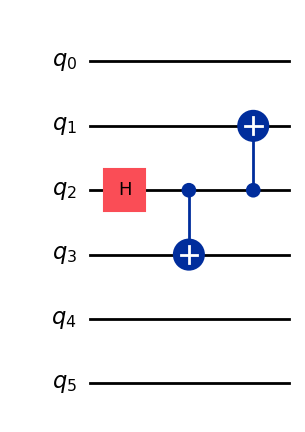

In [10]:
heisenberg_exact = HeisenbergModel(n_qubits, graphs[0])
ghz_circuit = heisenberg_exact.get_ghz_circuit(phase=0)
ghz_circuit.draw("mpl")

## Trotter simulation (Simulator, Noise free)

In [11]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}
lambda_refs = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]

    # lambda_ref はこの後も使うので、辞書として保存
    lambda_refs[f"sample{i}"] = np.sum(Js)  # Reference eigenvalue.

    heisenberg_sim = HeisenbergModel(n_qubits, graphs[i], backend=backend_sim)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=0)
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=1)
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=2)
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=3)
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/80
Creating circuits for sample 1/80
Creating circuits for sample 2/80
Creating circuits for sample 3/80
Creating circuits for sample 4/80
Creating circuits for sample 5/80
Creating circuits for sample 6/80
Creating circuits for sample 7/80
Creating circuits for sample 8/80
Creating circuits for sample 9/80
Creating circuits for sample 10/80
Creating circuits for sample 11/80
Creating circuits for sample 12/80
Creating circuits for sample 13/80
Creating circuits for sample 14/80
Creating circuits for sample 15/80
Creating circuits for sample 16/80
Creating circuits for sample 17/80
Creating circuits for sample 18/80
Creating circuits for sample 19/80
Creating circuits for sample 20/80
Creating circuits for sample 21/80
Creating circuits for sample 22/80
Creating circuits for sample 23/80
Creating circuits for sample 24/80
Creating circuits for sample 25/80
Creating circuits for sample 26/80
Creating circuits for sample 27/80
Creating circuits for sample 2

In [12]:
# Run jobs in batch

# For AerSimulator, we can't use job ids. Instead, we store the jobs in a list.
jobs = []
with Batch(backend=backend_sim):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/80
Running circuits for sample 1/80
Running circuits for sample 2/80
Running circuits for sample 3/80
Running circuits for sample 4/80
Running circuits for sample 5/80
Running circuits for sample 6/80
Running circuits for sample 7/80
Running circuits for sample 8/80
Running circuits for sample 9/80
Running circuits for sample 10/80
Running circuits for sample 11/80
Running circuits for sample 12/80
Running circuits for sample 13/80
Running circuits for sample 14/80
Running circuits for sample 15/80
Running circuits for sample 16/80
Running circuits for sample 17/80
Running circuits for sample 18/80
Running circuits for sample 19/80
Running circuits for sample 20/80
Running circuits for sample 21/80
Running circuits for sample 22/80
Running circuits for sample 23/80
Running circuits for sample 24/80
Running circuits for sample 25/80
Running circuits for sample 26/80
Running circuits for sample 27/80
Running circuits for sample 28/80
Running circuits for sam

In [15]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,2f8425fc-d906-4cac-87cd-f4d09900da40,0,DONE
1,dfd8c487-5de8-4abc-80f1-012302068856,1,DONE
2,a0115045-cdd6-4a7c-b73a-1e07eb56b819,2,DONE
3,82545305-2fcc-472a-8ea3-ac04bb2d052c,3,DONE
4,ca43cb4a-0a9c-4160-8331-850fbf780980,4,DONE
...,...,...,...
75,45ccfc5e-ab13-476c-a076-7004010b6529,75,DONE
76,69bc15f0-f3d0-4ec6-87c6-ab57548e5332,76,DONE
77,6fcee021-859d-4729-ba3d-52fc42b88e88,77,DONE
78,6debad31-24d2-4fcb-8709-8a38d08393d1,78,DONE


In [14]:
# Post-process
data_sim = []
probs_phase0_sim = {}
probs_phase1_sim = {}
probs_phase2_sim = {}
probs_phase3_sim = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim[f"sample{i}"] = {}
    probs_phase1_sim[f"sample{i}"] = {}
    probs_phase2_sim[f"sample{i}"] = {}
    probs_phase3_sim[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_df = pd.DataFrame(data_sim, columns=columns)
display(data_sim_df)

# Save the simulation data
data_sim_df.to_json(f"{path}/data_sim_df.json")
with open(f"{path}/probs_phase0_sim.json", "w") as f:
    json.dump(probs_phase0_sim, f)

with open(f"{path}/probs_phase1_sim.json", "w") as f:
    json.dump(probs_phase1_sim, f)

with open(f"{path}/probs_phase2_sim.json", "w") as f:
    json.dump(probs_phase2_sim, f)

with open(f"{path}/probs_phase3_sim.json", "w") as f:
    json.dump(probs_phase3_sim, f)

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No co

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.997367,0.040252,0.974962,0.096152,0.972094,0.188465,0.933605,0.199769,7.391106
1,1,1.0,0.986418,0.001405,0.956969,-0.115257,0.910609,-0.146262,0.874614,-0.151469,7.380861
2,2,1.0,0.995852,-0.053364,0.979728,-0.090975,0.979296,-0.079186,0.951882,-0.126306,1.560675
3,3,1.0,0.996624,-0.015779,0.985944,0.029551,0.953698,0.099610,0.922680,0.123570,5.663484
4,4,1.0,0.993478,0.007690,0.978034,-0.041359,0.962543,-0.129816,0.906745,-0.159644,1.889904
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1.0,0.996925,0.018317,0.992653,0.033611,0.986178,0.021380,0.980207,0.007056,1.463780
76,76,1.0,0.997273,0.046638,0.992061,0.082701,0.992303,0.095204,0.958700,0.192901,2.774891
77,77,1.0,1.000073,0.009892,0.998342,0.019698,0.993332,0.099688,0.989769,0.131797,1.709296
78,78,1.0,0.997879,-0.049714,0.985215,-0.109974,0.972721,-0.159620,0.944004,-0.254002,0.794244


## Trotter simulation (Simulator, Noisy)

In [16]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_sim_noisy = HeisenbergModel(
        n_qubits, graphs[i], backend=backend_sim_noisy
    )

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 1/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 2/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 3/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 4/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 5/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 6/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 7/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample 8/40
['IIXX', 'IIYY', 'IIZZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII']

Creating circuits for sample

In [17]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/40
Running circuits for sample 1/40
Running circuits for sample 2/40
Running circuits for sample 3/40
Running circuits for sample 4/40
Running circuits for sample 5/40
Running circuits for sample 6/40
Running circuits for sample 7/40
Running circuits for sample 8/40
Running circuits for sample 9/40
Running circuits for sample 10/40
Running circuits for sample 11/40
Running circuits for sample 12/40
Running circuits for sample 13/40
Running circuits for sample 14/40
Running circuits for sample 15/40
Running circuits for sample 16/40
Running circuits for sample 17/40
Running circuits for sample 18/40
Running circuits for sample 19/40
Running circuits for sample 20/40
Running circuits for sample 21/40
Running circuits for sample 22/40
Running circuits for sample 23/40
Running circuits for sample 24/40
Running circuits for sample 25/40
Running circuits for sample 26/40
Running circuits for sample 27/40
Running circuits for sample 28/40
Running circuits for sam

In [18]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,6788e52c-cd40-443c-ad73-4b1843a41dc8,0,DONE
1,c6ae84de-94b2-4b36-bc84-13a3b3fbb3fc,1,DONE
2,e1121d24-e025-43c7-9deb-ea30fefec6e2,2,DONE
3,f1db25fd-1c5c-4668-8f19-356434258887,3,DONE
4,316e6573-ca09-445e-a66e-8a8df121bc2c,4,DONE
5,44e20773-94c8-4b1f-97cc-18a8c86bc1f9,5,DONE
6,63f0447c-0a88-4498-ba88-a9a203c18fe8,6,DONE
7,f6c385e3-d7ad-43ec-beda-8be84126b5d3,7,DONE
8,99568857-0ada-4d9b-aef7-48c716df746a,8,DONE
9,3dc5185a-bfb1-4f85-a1ef-8858b2e3e3b8,9,DONE


In [19]:
# Post-process
data_sim_noisy = []
probs_phase0_sim_noisy = {}
probs_phase1_sim_noisy = {}
probs_phase2_sim_noisy = {}
probs_phase3_sim_noisy = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim_noisy[f"sample{i}"] = {}
    probs_phase1_sim_noisy[f"sample{i}"] = {}
    probs_phase2_sim_noisy[f"sample{i}"] = {}
    probs_phase3_sim_noisy[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim_noisy.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_noisy_df = pd.DataFrame(data_sim_noisy, columns=columns)
display(data_sim_noisy_df)

# Save the simulation data
data_sim_noisy_df.to_json(f"{path}/data_sim_noisy_df.json")
with open(f"{path}/probs_phase0_sim_noisy.json", "w") as f:
    json.dump(probs_phase0_sim_noisy, f)

with open(f"{path}/probs_phase1_sim_noisy.json", "w") as f:
    json.dump(probs_phase1_sim_noisy, f)

with open(f"{path}/probs_phase2_sim_noisy.json", "w") as f:
    json.dump(probs_phase2_sim_noisy, f)

with open(f"{path}/probs_phase3_sim_noisy.json", "w") as f:
    json.dump(probs_phase3_sim_noisy, f)

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.968750,0.900442,-0.137911,0.880010,-0.248033,0.882870,-0.288233,0.831752,-0.401868,0.285440
1,1,0.969727,0.894830,-0.197872,0.812946,-0.296737,0.737213,-0.451613,0.630850,-0.567480,1.439068
2,2,0.973633,0.914783,0.049048,0.906437,0.102600,0.871415,0.145381,0.845387,0.208130,3.932849
3,3,0.974609,0.909326,-0.089186,0.914140,-0.135021,0.893135,-0.198245,0.863666,-0.228573,0.491069
4,4,0.979492,0.904464,0.018972,0.904462,0.079784,0.882721,0.091971,0.840455,0.096663,3.379307
5,5,0.974609,0.925360,0.127848,0.895723,0.239646,0.850760,0.315055,0.816672,0.435965,4.666125
6,6,0.960938,0.916575,-0.046723,0.904519,-0.123217,0.916509,-0.181422,0.852016,-0.261550,0.617100
7,7,0.967773,0.916862,-0.085076,0.886625,-0.141445,0.854862,-0.207258,0.816620,-0.273974,0.808101
8,8,0.968750,0.920530,0.008328,0.892764,-0.035215,0.881497,0.011751,0.819130,-0.062268,1.805577
9,9,0.971680,0.918168,0.070922,0.920782,0.115385,0.901807,0.147235,0.901386,0.234710,2.279967
